In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import dLux as dl
from numpy import random
import scipy
from jax import grad
import jax
import equinox as eqx
import os

import optax
from IPython.display import clear_output


/home/jordan/anaconda3/envs/dLux/lib/python3.10/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


dLux warning: Jax is running in 32-bit, to enable 64-bit visit:
https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


In [2]:
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=5' # Use 8 CPU devices # might be causing a memory leak
jax.config.update("jax_enable_x64", True)
r2a = dl.utils.radians_to_arcseconds
a2r = dl.utils.arcseconds_to_radians

In [3]:
mask = np.load('TolimanMask_sidelobes.npy')

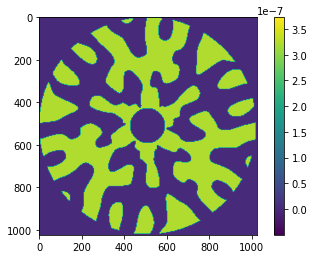

In [4]:
plt.imshow(mask)
plt.colorbar()

In [5]:
central_wav = (595+695)/2

# Generate mask and basic modelling parmaters
wavels = 1e-9 * np.linspace(595, 695, 5) # Wavelengths
aperture_diameter = 0.12
arcsec_per_pixel = 0.375
pixel_scale_out = dl.utils.arcseconds_to_radians(arcsec_per_pixel)
det_npix = 2048
wf_npix = 1024



In [6]:
osys = dl.utils.toliman(mask.shape[0], 100, detector_pixel_size=r2a(pixel_scale_out), extra_layers=[dl.AddOPD(mask)])
#source = dl.PointSource(wavelengths=wavels)
#osys = osys.set('AddOPD.opd', mask)

In [7]:
position = np.array([0.0,0.0])
flux = 1
separation = dl.utils.arcseconds_to_radians(8.0)
position_angle = np.pi/2
wavelengths = wavels

mysource = dl.BinarySource(position , flux, separation, position_angle, wavelengths = wavelengths)

1.5559713724653292
CPU times: user 4.07 s, sys: 541 ms, total: 4.61 s
Wall time: 3.18 s


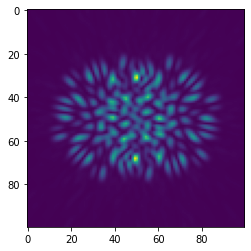

In [8]:
%%time
psf = osys.model(source=mysource)
plt.imshow(psf)
print(np.sum(psf))

In [9]:
def make_image(params, osys):
    position = [a2r(params[0]), a2r(params[1])]
    separation = a2r(params[2])
    position_angle = params[3]
    
    source = dl.BinarySource(position , flux, separation, position_angle, wavelengths = wavelengths)
    image = osys.model(source=source)
    image /= np.sum(image)
    return image

@eqx.filter_jit
def compute_loss(params, osys, input_image):
    fmodel_image = make_image(params, osys)
    noise = np.sqrt(input_image)  # does this actually do anything?
    residual = (input_image - fmodel_image)/noise
    
    chi2 = np.sum(residual**2)
    return chi2

def apply_photon_noise(image, seed = 0):
    key = jax.random.PRNGKey(seed)
    image_noisy = jax.random.poisson(key = key,lam = image)
    return image_noisy


1.0000000000000002
CPU times: user 2.95 s, sys: 385 ms, total: 3.33 s
Wall time: 1.84 s


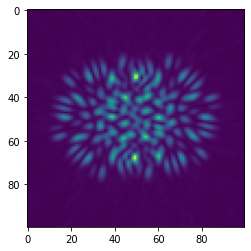

In [10]:
%%time
target_image = apply_photon_noise(make_image(np.array([0.1,0.13,8.003,(np.pi/2)*1.01]), osys)*1e12)
#target_image = make_image(np.array([0,15,8,np.pi/3]), osys)
target_image /= np.sum(target_image)
plt.imshow(target_image)
print(np.sum(target_image))

In [11]:
%%time
start_learning_rate = 1e-3
optimizer = optax.adam(start_learning_rate)

params = np.array([0,0,8,np.pi/2])
opt_state = optimizer.init(params)

true_params = np.array([0.1,0.13,8.003,(np.pi/2)*1.01])

for i in range(10):
    print(params)
    grads = jax.grad(compute_loss)(params, osys, target_image)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
print(params)
    
final_image = make_image(params, osys)
residual = target_image - final_image
mse = np.mean(residual**2)
print('{:.3e}'.format(mse))
print('{:.3e}'.format(np.abs(true_params[2] - params[2])))

[0.         0.         8.         1.57079633]
[9.99999988e-04 9.99999990e-04 7.99900000e+00 1.57179633e+00]
[1.99959144e-03 1.99960437e-03 7.99800653e+00 1.57279398e+00]
[2.99850215e-03 2.99855495e-03 7.99702553e+00 1.57378749e+00]
[3.99646157e-03 3.99659960e-03 7.99606449e+00 1.57477490e+00]
[4.99320206e-03 4.99349372e-03 7.99513268e+00 1.57575404e+00]
[5.98846012e-03 5.98900157e-03 7.99424135e+00 1.57672257e+00]
[6.98197750e-03 6.98289750e-03 7.99340371e+00 1.57767792e+00]
[7.97350239e-03 7.97496699e-03 7.99263457e+00 1.57861736e+00]
[0.00896279 0.00896501 7.99194953 1.57953796]
[0.00994961 0.00995283 7.99136363 1.58043663]
1.995e-09
1.164e-02
CPU times: user 33.9 s, sys: 2.96 s, total: 36.8 s
Wall time: 9.26 s


| optimizer | time | mse | 
|-----------|------|-----------|
| adabelief | 39.7 | 5.119e-10 |
| adagrad   | 39.3 | 9.472e-10 |
| adam      | 39.8 | 3.399e-10 |
| sm3       | 39.8 | 2.609e-09 |
| noisy_sgd | 40.0 | 4.842e-09 |
| radam     | 40.1 | 5.309e-09 |
| rmsprop   | 39.7 | 3.213e-11 |
| sgd       | 39.8 | 5.346e-09 |
| yogi      | 40.0 | 3.393e-10 |

Best: rmsprop  --> adam --> yogi --> adabelief

on noisy image (1e9 photons) (some times might be wrong due to a memory leak...)

| optimizer | time | mse | 
|-----------|------|-----------|
| adabelief | 39.5 | 5.108e-10 |
| adagrad   | 39.6 | 9.475e-10 |
| adam      | 39.5 | 3.389e-10 |
| sm3       | 39.5 | 2.607e-09 |
| noisy_sgd | 39.3 | 5.147e-09 |
| radam     | 48.6 | 5.119e-09 |
| rmsprop   | 39.9  | 3.460e-11 |  
| sgd       | 124  | 5.049e-09 |
| yogi      | 68.0 | 3.382e-10 |


learning rate 1e-1 (10 iters)

|optimizer  | error (1e9)| error (1e12)|
|-----------|------------|-------------|
| rmsprop   | 5.335e-03  | 5.283e-03   | 
| adam      | 4.458e-02  | 4.458e-02   |

learning rate 1e-2 (10 iters)

|optimizer  | error (1e9)| error (1e12)|
|-----------|------------|-------------|
| rmsprop   | 6.123e-05  | 1.033e-04   | 
| adam      | 1.048e-02  | 1.049e-02   |

learning rate 1e-3 (10 iters)

|optimizer  | error (1e9)| error (1e12)|
|-----------|------------|-------------|
| rmsprop   | 8.150e-03  | 8.150e-03   | 
| adam      | 1.169e-02  | 1.167e-02   |


In [12]:
%%time
start_learning_rate = 1e-2
optimizer = optax.rmsprop(start_learning_rate)
max_iter = 25

params = np.array([0,0,8,np.pi/2])
opt_state = optimizer.init(params)

true_params = np.array([0.1,0.13,8.003,(np.pi/2)*1.01])

for i in range(max_iter):
    if i == max_iter - 1:
        print('Maximum iterations hit')
    #print(params)
    grads = jax.grad(compute_loss)(params, osys, target_image)
    print(grads)
    print('{:.3e}'.format(np.abs(true_params[2] - params[2])))
    if np.max(np.abs(grads)) < 5e-2:
        print('Gtol satisfied')
        break
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
#print(params)
    
final_image = make_image(params, osys)
residual = target_image - final_image
mse = np.mean(residual**2)
print('{:.3e}'.format(mse))
print('{:.3e}'.format(np.abs(true_params[2] - params[2])))

[-0.80427719 -1.0022911   0.02790783 -2.15714078]
3.000e-03
[-0.51008423 -0.70623609 -0.06523933  1.89167627]
3.462e-02
[-0.36998482 -0.54399722 -0.0037954  -0.65643364]
5.319e-03
[-0.27345787 -0.43768384 -0.00498452  0.21951874]
3.525e-03
[-0.2068763  -0.36125175 -0.00099922 -0.071618  ]
1.049e-03
[-0.15550791 -0.29862707 -0.00067743  0.03120281]
5.263e-04
[-0.11612983 -0.24692734 -0.00027218 -0.01230736]
1.525e-04
[-8.56006508e-02 -2.03339369e-01 -1.29894993e-04  7.29437628e-03]
5.775e-06
[-6.21132793e-02 -1.66460124e-01 -4.47783520e-05 -3.82194877e-03]
8.541e-05
[-4.42170048e-02 -1.35190742e-01  9.46443183e-09  2.71648357e-03]
1.143e-04
[-3.07890535e-02 -1.08762858e-01  1.44710318e-05 -2.04214770e-03]
1.143e-04
[-2.09061800e-02 -8.65533688e-02  2.39648122e-05  1.63727640e-03]
1.040e-04
[-1.37897254e-02 -6.80415533e-02  1.97276033e-05 -1.66407516e-03]
8.581e-05
[-8.80206799e-03 -5.27733648e-02  2.07318465e-05  1.60884387e-03]
7.007e-05
[-5.40160131e-03 -4.03284735e-02  1.24001098e-05

In [13]:
print(np.abs(true_params - params))

[6.88625856e-04 6.27986076e-03 5.26393432e-05 2.31422845e-05]


Text(0.5, 1.0, 'angle')

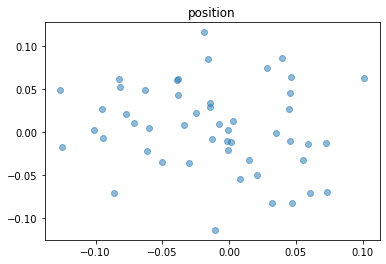

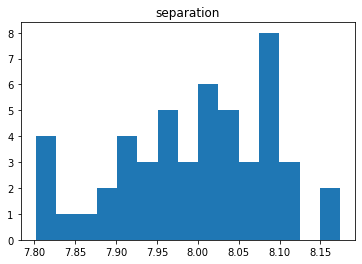

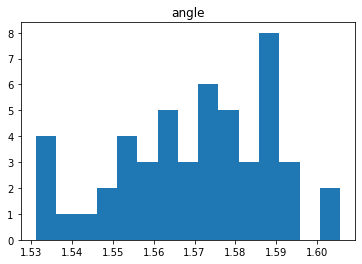

In [14]:
num_images = 50

key = jax.random.PRNGKey(0)
position_vec = 0.05*jax.random.normal(key, (num_images,2))
separation_vec = 8 + 0.1*jax.random.normal(key, (1, num_images))
angle_vec = np.pi/2 + 0.02*jax.random.normal(key, (1,num_images))

plt.figure()
plt.scatter(position_vec[:,0], position_vec[:,1], alpha = 0.5)
plt.title('position')
 
plt.figure()
plt.hist(separation_vec[0,:], bins = 15)
plt.title('separation')

plt.figure()
plt.hist(angle_vec[0,:], bins = 15)
plt.title('angle')

Maximum iterations hit
Iteration: 49/50


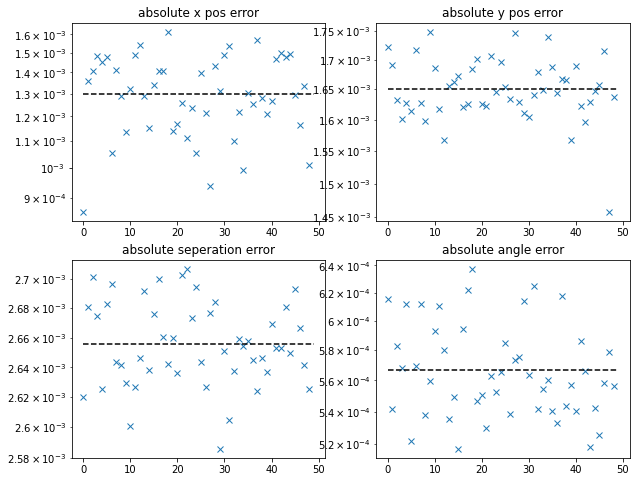

1.8900 4.275e-02
[0.10572503 0.49548959 1.00472095 0.98312006]
3.8204 4.061e-02
[0.73870092 0.85210073 1.00006675 0.99144488]
1.6497 3.858e-02
[1.3253376  1.18114826 0.99663213 1.00301256]
0.7567 3.665e-02
[1.62130723 1.35296803 0.99481781 1.01017611]
2.2516 3.482e-02
[1.61930272 1.35679602 0.99443667 1.01044201]
2.3082 3.308e-02
[1.45145105 1.26494379 0.99500336 1.00637402]
1.4517 3.143e-02
[1.21433852 1.13280844 0.99610589 1.00079578]
0.3240 2.985e-02
[0.97245259 0.99633738 0.99745946 0.99586364]
0.7516 2.836e-02
[0.77427244 0.88193969 0.99886413 0.99301668]
1.3552 2.694e-02
[0.6511619  0.807598   1.00017048 0.99264965]
1.4905 2.560e-02
[0.6102012  0.77859342 1.00126776 0.99426187]
1.2500 2.432e-02
[0.6385337  0.78876459 1.00208626 0.99700385]
0.7678 2.310e-02
[0.71525736 0.82704168 1.00260038 1.00002452]
0.2179 2.195e-02
[0.81918347 0.8820626  1.00282347 1.00261283]


In [ ]:
start_learning_rate = 4.5e-2
max_iter = 50

# exponential_decay_scheduler = optax.exponential_decay(init_value=start_learning_rate, transition_steps=max_iter,
#                                                       decay_rate=0.9, transition_begin=1,
#                                                       staircase=False)

opt = optax.rmsprop(learning_rate=start_learning_rate)
flux = 1e12
gtol = 9e-4

estimated_pos_x = np.zeros(num_images)
estimated_pos_y = np.zeros(num_images)
estimated_sep   = np.zeros(num_images)
estimated_ang   = np.zeros(num_images)

plt.ion()
for i in range(num_images):
    # Define true/target params
    true_params = np.array([position_vec[i,0], position_vec[i,1], separation_vec[0,i], angle_vec[0,i]])
    
    # Create target image
    target_image = apply_photon_noise(make_image(true_params, osys)*flux)
    target_image /= np.sum(target_image)
    
    # Default starting params
    #params = np.array([0,0,8,np.pi/2])
    params = 1.01*true_params
    opt = optax.inject_hyperparams(optax.adam)(learning_rate=start_learning_rate)
    opt_state = opt.init(params)
    
    # Do gradient descent
    lr = start_learning_rate
    for j in range(max_iter):
        lr *= 0.95
        #_, opt_update = optax.adam(learning_rate=lr) # i dont think this is actually updating the lr
        grads = jax.grad(compute_loss)(params, osys, target_image)
        #print(grads)
        print('{:.4f}'.format(np.sum(np.abs(grads))), '{:.3e}'.format(lr))
        overall_gtol = np.sum(np.abs(grads))
        
        if overall_gtol < gtol:
            clear_output(wait=True)
            print('Gtol satisfied')
            break
        opt_state.hyperparams['learning_rate'] = lr
        updates, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        print(params/true_params)
        if j == max_iter - 1:
            clear_output(wait=True)
            print('Maximum iterations hit')
        
    estimated_params = params
    
    estimated_pos_x = estimated_pos_x.at[i].set(estimated_params[0])
    estimated_pos_y = estimated_pos_y.at[i].set(estimated_params[1])
    estimated_sep   = estimated_sep.at[i].set(estimated_params[2])
    estimated_ang   = estimated_ang.at[i].set(estimated_params[3])
    
    # Make plots
    
    print('Iteration: {}/{}'.format(i+1,num_images))
    plt.figure(figsize = (10,8))
    plt.subplot(2,2,1)
    plt.plot(np.abs(estimated_pos_x - position_vec[:,0])[:i+1], 'x')
    plt.hlines(np.mean(np.abs(estimated_pos_x - position_vec[:,0])[:i+1]), 0, i+1, ls = '--', color = 'black')
    plt.title('absolute x pos error')
    plt.yscale('log')

    plt.subplot(2,2,2)
    plt.plot(np.abs(estimated_pos_y - position_vec[:,1])[:i+1], 'x')
    plt.hlines(np.mean(np.abs(estimated_pos_y - position_vec[:,1])[:i+1]), 0, i+1, ls = '--', color = 'black')
    plt.title('absolute y pos error')
    plt.yscale('log')

    plt.subplot(2,2,3)
    plt.plot(np.abs(estimated_sep - separation_vec)[0,:i+1], 'x')
    plt.hlines(np.mean(np.abs(estimated_sep - separation_vec)[0,:i+1]), 0, i+1, ls = '--', color = 'black')
    plt.title('absolute seperation error')
    plt.yscale('log')

    plt.subplot(2,2,4)
    plt.plot(np.abs(estimated_ang - angle_vec)[0,:i+1], 'x')
    plt.hlines(np.mean(np.abs(estimated_ang - angle_vec)[0,:i+1]), 0, i+1, ls = '--', color = 'black')
    plt.title('absolute angle error')
    plt.yscale('log')
    plt.show()

In [ ]:
print(estimated_sep)
print(separation_vec[0])
print(np.abs(estimated_sep - separation_vec)[0,:i+1])

plt.plot(np.abs(estimated_sep - separation_vec)[0,:i+1], 'x')
plt.yscale('log')

In [ ]:
plt.figure(figsize = (10,8))
plt.subplot(2,2,1)
plt.plot(np.abs(estimated_pos_x - position_vec[:,0])[:i+1], 'x')
plt.title('absolute x pos error')
plt.yscale('log')

plt.subplot(2,2,2)
plt.plot(np.abs(estimated_pos_x - position_vec[:,1])[:i+1], 'x')
plt.title('absolute y pos error')
plt.yscale('log')

plt.subplot(2,2,3)
plt.plot(np.abs(estimated_sep - separation_vec[:,0])[:i+1], 'x')
plt.title('absolute seperation error')
plt.yscale('log')

plt.subplot(2,2,4)
plt.plot(np.abs(estimated_ang - angle_vec[:,0])[:i+1], 'x')
plt.title('absolute angle error')
plt.yscale('log')
plt.show()